# Exploratory Data Analysis for High School Running Continued Success Factors 


#### - The data are scraped from several running websites 


# Does the Athlete Make the Coach or the Coach Make the Athlete?
OR
# Does Success in High School Running Predict Success in College?

California high schools have produced hundreds of amazing runners that have gone on to continue to run and compete in college.  Are there any lessons learned or obvious trends in the data that can help predict success factors for star high school runners as they attempt to choose the "right" university for them
* What are the strongest factors of succes
s for high school running?
* Where do California High School Runners go to run in college?
* Can we predict whether a high school athlete will continue be successful at their chosen college level program?

Deciding to compete in college at the NCAA Division 1 level takes a high level of success in high school and focus and determination in college.  Not all high schoolers will go on to continued success.  Is this a matter of their collegiate academic pressures? their changing interests and expanded horizons that college environment affords? Does the level of training or over-training in high school determine if they still have room for development in college?  

What take-aways will the data reveal? Some data sources to investigate: 
** https://www.xcstats.com/search-xc-california.php - various XC and track stats are kept here
** https://www.rtspt.com/events/cif/xc2022/mp/#event1 - CIF XC State Results from past 10 years
** https://www.strava.com/activities/8387865995/overview - Strava contains a wealth of runner information and does have a public API - I also am trying to meet with Strava's head AI Data Scientist
** https://athletic.net  - contains athlete profiles for both High School and Collegiate Records/times 
** https://www.milesplit.com/signings - several places provide data on who signed to go run at which college

Data Collection: will have to be manual and pieced together from various sources
** Pull lists of top California runners (on state course or local Crystal Springs XC course) 
** Determine where runners went to college and if they ran
** Obtain Athlete data - Name, DOB, Multi-Sport?, Years competing in HS?, Years Competing in MS?, Years Conmpeting in College?, Event Specialty, HS Events, College Events, GoPro? (Y/N), 
** Obtain High School data - School Name, Coach, Division/Size, Graduation Year, Location, Private/Public,  HS Event PRs
** Obtain College data - School Name, Coach, Division/Size, Graduation Year, Gap Year?, Location, In/Out of State?, Event PRS

Question: Is there a correlation or trend between where the athlete went to HS and College and whether that athlete will continue to develop/improve in their main (2) events? Do some high schools just create superstar runners? Do some colleges create superstar runners? Are there any factors that make it more likely to have a full HS/Collegiate running career? Prediction for who might go pro?

# Standard Package Imports

In [151]:
import os
import sys
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import plotly.express as px
import seaborn as sns


import datetime
from datetime import timedelta


from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression

#matplotlib.style.use("Solarize_Light2")
matplotlib.style.use("ggplot")

%matplotlib inline

# Standard functions utilized throughout the notebook

In [2]:
def check_null(df):
    """
    Returns percentage of rows containing missing data
    """
    return df.isna().sum() * 100/len(df)


def get_missing_dates(series, start_date, end_date, freq="D"):
    """
    Returns the dates which are missing in the series
    date_sr between the start_date and end_date
    
    series: Series consisting of date
    start_date: Start date in String format
    end_date: End date in String format
    """
    return pd.date_range(
        start=start_date, end=end_date, freq=freq).difference(series)


def check_duplicate(df, subset):
    """
    Returns if there are any duplicate rows in the DataFrame.
    
    df: DataFrame under consideration
    subset: Optional List of feature names based on which 
            duplicate rows are being identified. 
    """
    if subset is not None: 
        return df.duplicated(subset=subset, keep=False).sum()
    else:
        return df.duplicated(keep=False).sum()


def create_date_features(source_df, target_df, feature_name):
    '''
    Create new features related to dates
    
    source_df : DataFrame consisting of the timestamp related feature
    target_df : DataFrame where new features will be added
    feature_name : Name of the feature of date type which needs to be decomposed.
    '''
    target_df.loc[:, 'year'] = source_df.loc[:, feature_name].dt.year.astype('uint16')
    target_df.loc[:, 'month'] = source_df.loc[:, feature_name].dt.month.astype('uint8')
    target_df.loc[:, 'quarter'] = source_df.loc[:, feature_name].dt.quarter.astype('uint8')
    target_df.loc[:, 'weekofyear'] = source_df.loc[:, feature_name].dt.isocalendar().week.astype('uint8')
    
    target_df.loc[:, 'hour'] = source_df.loc[:, feature_name].dt.hour.astype('uint8')
    
    target_df.loc[:, 'day'] = source_df.loc[:, feature_name].dt.day.astype('uint8')
    target_df.loc[:, 'dayofweek'] = source_df.loc[:, feature_name].dt.dayofweek.astype('uint8')
    target_df.loc[:, 'dayofyear'] = source_df.loc[:, feature_name].dt.dayofyear.astype('uint8')
    target_df.loc[:, 'is_month_start'] = source_df.loc[:, feature_name].dt.is_month_start
    target_df.loc[:, 'is_month_end'] = source_df.loc[:, feature_name].dt.is_month_end
    target_df.loc[:, 'is_quarter_start']= source_df.loc[:, feature_name].dt.is_quarter_start
    target_df.loc[:, 'is_quarter_end'] = source_df.loc[:, feature_name].dt.is_quarter_end
    target_df.loc[:, 'is_year_start'] = source_df.loc[:, feature_name].dt.is_year_start
    target_df.loc[:, 'is_year_end'] = source_df.loc[:, feature_name].dt.is_year_end
    
    # This is of type object
    target_df.loc[:, 'month_year'] = source_df.loc[:, feature_name].dt.to_period('M')
    
    return target_df


def plot_boxh_groupby(df, feature_name, by):
    """
    Box plot with groupby
    
    df: DataFrame
    feature_name: Name of the feature to be plotted
    by: Name of the feature based on which groups are created
    """
    df.boxplot(column=feature_name, by=by, vert=False, 
                              figsize=(10, 6))
    plt.title(f'Distribution of {feature_name} by {by}')
    plt.show()
    

def plot_hist(df, feature_name, kind='hist', bins=100, log=True):
    """
    Plot histogram.
    
    df: DataFrame
    feature_name: Name of the feature to be plotted.
    """
    if log:
        df[feature_name].apply(np.log1p).plot(kind='hist', 
                                              bins=bins, 
                                              figsize=(15, 5), 
                                              title=f'Distribution of log1p[{feature_name}]')
    else:
        df[feature_name].plot(kind='hist', 
                              bins=bins, 
                              figsize=(15, 5), 
                              title=f'Distribution of {feature_name}')
    plt.show()


def plot_ts(series, figsize=(20, 6), title=None, xlabel="", ylabel=""):
    """
    Plot Time Series data. The series object should have date or time as index.
    
    series: Series object to be plotted.
    """
    series.plot(figsize=figsize, title=title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()


def plot_barh(df, feature_name, normalize=True, 
              kind='barh', figsize=(15,5), sort_index=False, title=None):
    """
    Plot barh for a particular feature
    
    kind : Type of the plot
    
    """
    if sort_index==True:
        df[feature_name].value_counts(
                normalize=normalize, dropna=False).sort_index().plot(
                kind=kind, figsize=figsize, grid=True,
                title=title)
    else:   
        df[feature_name].value_counts(
                normalize=normalize, dropna=False).sort_values().plot(
                kind=kind, figsize=figsize, grid=True,
                title=title)
    
    plt.legend()
    plt.show()


def plot_boxh(df, feature_name, kind='box', log=True):
    """
    Box plot
    """
    if log:
        df[feature_name].apply(np.log1p).plot(kind='box', vert=False, 
                                                  figsize=(10, 6), 
                                                  title=f'Distribution of log1p[{feature_name}]')
    else:
        df[feature_name].plot(kind='box', vert=False, 
                              figsize=(10, 6), 
                              title=f'Distribution of {feature_name}')
    plt.show()
    

def plot_scatter(df, feature_x, feature_y, figsize=(10,10), 
                 title=None, xlabel=None, ylabel=None):
    """
    Plot satter     
    """
    df.plot.scatter(feature_x, feature_y, 
                    figsize=(8, 6), title=title, 
                    legend=None)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

# Data Description

The challenge with this project was the initial data collection - there is no one source of high school and college running data but rather multiple sites depending on the timer/company used for the various races and depending on the geographic location of the high school and then colleges. 

**Geographic Scoping:** the decision was made to focus on California high school runners since the CIF California State XC results are the most all-encompassing and enclusive of the runners in the state broken across five different "divisions" based on school size. 

**Gender Specific:** the decision for this analysis was to focus on the development of male high school runners through to the collegiate and professional level since there are dramatic differences in the timing and pace of female running development/maturity versus male maturity and, due to a number of factors, the belief is that due to the introduction of testosterone in the male development cycle it is a perhaps more predictive progression to follow. In any case, the decision was made to only follow the trajectory of male runners. 

**Year Scoping:** Due to the complications of the Covid-19 pandemic on the athletes' running careers and college plans this project decided to only focus on athletes from the high school years 2014-2016. That would allow the assessment of their progress into collegiate running to be 2016-2020 timeframe before the pandemic. 


There are the following data CSV files compiled manually from various websites: 

   **California State XC Results (CIF_XC.csv):** 
   It consists of the state championship 5K cross country results by athlete, division, 
       school, and district/section, along with the 5K time and average pace run per 
       athlete.  The data includes the top 30 male runners from each division. The columns include: 
 <pre>
    - YEAR
    - DATE
    - MEET
    - COURSE
    - DISTANCE (meters)
    - WEATHER
    - DIVISION 
    - PLACE   
    - FIRST_NAME, LAST_NAME, FULL_NAME
    - YEAR
    - SCHOOL  
    - SECTION
    - OVERALL TIME  
    - AVG_PACE      
</pre>      

**NOTE: currently this file only has results from the year 2016 for this EDA (Exploratory Data Assessment) phase - the additional data will be added by the end of this project but it is time consuming so for this stage just 2016 data is assessed**

# California Cross Country State Championships Results 


In [3]:
# Read the preliminary state xc results data from 2016
DATA_DIR = "/Users/tinalount/Desktop/Data/"

XC_2016_df = pd.read_csv(f"{DATA_DIR}/CIF_XC_2016.csv")

In [4]:
XC_2016_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   YEAR               170 non-null    int64 
 1   DATE               170 non-null    object
 2   MEET               170 non-null    object
 3   COURSE             170 non-null    object
 4   DISTANCE (meters)  170 non-null    int64 
 5   WEATHER            170 non-null    object
 6   WEATHER2           170 non-null    int64 
 7   DIVISION           170 non-null    int64 
 8   PLACE              170 non-null    int64 
 9   FIRST_NAME         170 non-null    object
 10  LAST_NAME          170 non-null    object
 11  FULL_NAME          170 non-null    object
 12  YEAR.1             170 non-null    object
 13  SCHOOL             170 non-null    object
 14  SECTION            170 non-null    object
 15  OVERALL TIME       170 non-null    object
 16  AVG_PACE           140 non-null    object
dt

In [5]:
XC_2016_df.head()

,YEAR,DATE,MEET,COURSE,DISTANCE (meters),WEATHER,WEATHER2,DIVISION,PLACE,FIRST_NAME,LAST_NAME,FULL_NAME,YEAR.1,SCHOOL,SECTION,OVERALL TIME,AVG_PACE
0,2016,11/29/2014,CIF State Cross Country,Woodward Park,5000,Sunny,70,4,1,Callum,Bolger,Callum Bolger,SR,San Luis Obispo,SS,14:57.4,04:48.5
1,2016,11/29/2014,CIF State Cross Country,Woodward Park,5000,Sunny,70,4,2,Jared,Rodriguez,Jared Rodriguez,SR,Foothill Technology,SS,15:29.3,04:58.8
2,2016,11/29/2014,CIF State Cross Country,Woodward Park,5000,Sunny,70,4,3,Joseph,Garcia,Joseph Garcia,SR,Salesian,SS,15:33.9,05:00.3
3,2016,11/29/2014,CIF State Cross Country,Woodward Park,5000,Sunny,70,4,4,Ryan,Cutter,Ryan Cutter,SR,Hercules,NCS,15:39.9,05:02.2
4,2016,11/29/2014,CIF State Cross Country,Woodward Park,5000,Sunny,70,4,5,Anthony,Grover,Anthony Grover,FR,JSerra,SS,15:40.1,05:02.3


   
  ### Loading XC State Championships Results Data

In [6]:
# convert the "DATE" column to a date object
XC_2016_df['DATE'] = pd.to_datetime(XC_2016_df['DATE'])

In [7]:
XC_2016_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   YEAR               170 non-null    int64         
 1   DATE               170 non-null    datetime64[ns]
 2   MEET               170 non-null    object        
 3   COURSE             170 non-null    object        
 4   DISTANCE (meters)  170 non-null    int64         
 5   WEATHER            170 non-null    object        
 6   WEATHER2           170 non-null    int64         
 7   DIVISION           170 non-null    int64         
 8   PLACE              170 non-null    int64         
 9   FIRST_NAME         170 non-null    object        
 10  LAST_NAME          170 non-null    object        
 11  FULL_NAME          170 non-null    object        
 12  YEAR.1             170 non-null    object        
 13  SCHOOL             170 non-null    object        
 14  SECTION   

In [8]:
# check for nulls
check_null(XC_2016_df)

YEAR                  0.000000
DATE                  0.000000
MEET                  0.000000
COURSE                0.000000
DISTANCE (meters)     0.000000
WEATHER               0.000000
WEATHER2              0.000000
DIVISION              0.000000
PLACE                 0.000000
FIRST_NAME            0.000000
LAST_NAME             0.000000
FULL_NAME             0.000000
YEAR.1                0.000000
SCHOOL                0.000000
SECTION               0.000000
OVERALL TIME          0.000000
AVG_PACE             17.647059
dtype: float64

 ### Loading HS to College Running Results Data Mapping File

In [9]:
# Load File with College Data added to High School XC Results File

DATA_DIR = "/Users/tinalount/Desktop/Data/"

df_college = pd.read_csv(f"{DATA_DIR}/CIF_XC_2016 HS_to_COLLEGE.csv")



In [10]:
def custom_parser(time_str):
    try:
        return datetime.datetime.strptime(time_str, '%M:%S.%f')
    except ValueError:
        return pd.NaT  # return Not a Time (NaT) for invalid values
    
df_college = pd.read_csv(f"{DATA_DIR}/CIF_XC_2016 HS_to_COLLEGE.csv", 
                         parse_dates=["OVERALL TIME", "AVG_PACE", "BEST_HS_MILE","BEST_HS_1500","BEST_HS_1600",
                                      "BEST_COLLEGE1_8K_XC_TIME",
                                    "BEST_COLLEGE1_1500", "BEST_COLLEGE1_MILE", "BEST_COLLEGE1_5K","BEST_COLLEGE1_3K",
                                    "BEST_COLLEGE2_8K_TIME", "BEST_COLLEGE2_1500", "BEST_COLLEGE2_MILE", 
                                   "BEST_COLLEGE2_5K","BEST_COLLEGE2_3K"], 
                          date_parser=lambda x: pd.to_datetime(x, format='%M:%S.%f', errors='coerce'))   

In [11]:
print(f"Shape of the Running Data: {df_college.shape}")
print("\n")
#df_college.head()

Shape of the Running Data: (150, 47)




In [12]:
df_college.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 47 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   YEAR                      150 non-null    int64         
 1   DATE                      150 non-null    object        
 2   MEET                      150 non-null    object        
 3   COURSE                    150 non-null    object        
 4   DISTANCE (meters)         150 non-null    int64         
 5   WEATHER                   150 non-null    object        
 6   WEATHER2                  150 non-null    int64         
 7   DIVISION                  150 non-null    int64         
 8   PLACE                     150 non-null    int64         
 9   FIRST_NAME                150 non-null    object        
 10  LAST_NAME                 150 non-null    object        
 11  FULL_NAME                 150 non-null    object        
 12  GRADE                 

In [13]:
df_college.head()

,YEAR,DATE,MEET,COURSE,DISTANCE (meters),WEATHER,WEATHER2,DIVISION,PLACE,FIRST_NAME,...,COLL2_OUT_OF_STATE,COLLEGE2_DIV,BEST_COLLEGE2_8K_TIME,BEST_COLLEGE2_1500,BEST_COLLEGE2_MILE,BEST_COLLEGE2_5K,BEST_COLLEGE2_3K,COL2_PROFILE_TFRRS,COL2_PROFILE,MISC
0,2016,11/29/14,CIF State Cross Country,Woodward Park,5000,Sunny,70,4,1,Callum,...,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaN,NaN,NaN
1,2016,11/29/14,CIF State Cross Country,Woodward Park,5000,Sunny,70,4,2,Jared,...,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaN,NaN,NaN
2,2016,11/29/14,CIF State Cross Country,Woodward Park,5000,Sunny,70,4,3,Joseph,...,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaN,NaN,NaN
3,2016,11/29/14,CIF State Cross Country,Woodward Park,5000,Sunny,70,4,4,Ryan,...,1.0,1.0,1900-01-01 00:24:32.600,NaT,1900-01-01 00:04:08.600,1900-01-01 00:14:02.400,1900-01-01 00:08:13.300,https://www.tfrrs.org/athletes/7891934/Villano...,https://www.tfrrs.org/athletes/7891934/Villano...,NaN
4,2016,11/29/14,CIF State Cross Country,Woodward Park,5000,Sunny,70,4,5,Anthony,...,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaN,NaN,NaN


In [14]:
df_college.iloc[:, :20].head()

,YEAR,DATE,MEET,COURSE,DISTANCE (meters),WEATHER,WEATHER2,DIVISION,PLACE,FIRST_NAME,LAST_NAME,FULL_NAME,GRADE,SCHOOL,SECTION,OVERALL TIME,AVG_PACE,BEST_HS_MILE,BEST_HS_1500,BEST_HS_1600
0,2016,11/29/14,CIF State Cross Country,Woodward Park,5000,Sunny,70,4,1,Callum,Bolger,Callum Bolger,SR,San Luis Obispo,SS,1900-01-01 00:14:57.400,1900-01-01 00:04:48.500,1900-01-01 00:04:05.600,NaT,1900-01-01 00:04:07.700
1,2016,11/29/14,CIF State Cross Country,Woodward Park,5000,Sunny,70,4,2,Jared,Rodriguez,Jared Rodriguez,SR,Foothill Technology,SS,1900-01-01 00:15:29.300,1900-01-01 00:04:58.800,NaT,NaT,NaT
2,2016,11/29/14,CIF State Cross Country,Woodward Park,5000,Sunny,70,4,3,Joseph,Garcia,Joseph Garcia,SR,Salesian,SS,1900-01-01 00:15:33.900,1900-01-01 00:05:00.300,NaT,NaT,1900-01-01 00:04:25.200
3,2016,11/29/14,CIF State Cross Country,Woodward Park,5000,Sunny,70,4,4,Ryan,Cutter,Ryan Cutter,SR,Hercules,NCS,1900-01-01 00:15:39.900,1900-01-01 00:05:02.200,1900-01-01 00:04:21.900,1900-01-01 00:03:48.400,NaT
4,2016,11/29/14,CIF State Cross Country,Woodward Park,5000,Sunny,70,4,5,Anthony,Grover,Anthony Grover,FR,J Serra,SS,1900-01-01 00:15:40.100,1900-01-01 00:05:02.300,1900-01-01 00:04:15.200,NaT,1900-01-01 00:04:10.600


#### Display the Data in a nicer string format to review: 

In [15]:
## Display Data in a readable format

In [16]:
# LOADING DATA AS DATE TIME 
def custom_parser(time_str):
    try:
        return datetime.datetime.strptime(time_str, '%M:%S.%f')
    except ValueError:
        return pd.NaT  # return Not a Time (NaT) for invalid values
    
df_college = pd.read_csv(f"{DATA_DIR}/CIF_XC_2016 HS_to_COLLEGE.csv", 
                         parse_dates=["OVERALL TIME", "AVG_PACE", "BEST_HS_MILE","BEST_HS_1500","BEST_HS_1600",
                                      "BEST_COLLEGE1_8K_XC_TIME",
                                    "BEST_COLLEGE1_1500", "BEST_COLLEGE1_MILE", "BEST_COLLEGE1_5K","BEST_COLLEGE1_3K",
                                    "BEST_COLLEGE2_8K_TIME", "BEST_COLLEGE2_1500", "BEST_COLLEGE2_MILE", 
                                   "BEST_COLLEGE2_5K","BEST_COLLEGE2_3K"], 
                          date_parser=lambda x: pd.to_datetime(x, format='%M:%S.%f', errors='coerce'))   
                          #date_parser=lambda x: 'a') 

In [17]:
# Create a new DataFrame object
df_display = df_college.copy()


In [18]:
#display the data in a nice format for viewing (but this converts it to a string)
df_display[["OVERALL TIME", "AVG_PACE", "BEST_HS_MILE","BEST_HS_1500","BEST_HS_1600",
                                      "BEST_COLLEGE1_8K_XC_TIME",
                                    "BEST_COLLEGE1_1500", "BEST_COLLEGE1_MILE", "BEST_COLLEGE1_5K","BEST_COLLEGE1_3K",
                                    "BEST_COLLEGE2_8K_TIME", "BEST_COLLEGE2_1500", "BEST_COLLEGE2_MILE", 
                                   "BEST_COLLEGE2_5K","BEST_COLLEGE2_3K"]] = df_college[["OVERALL TIME", "AVG_PACE", "BEST_HS_MILE","BEST_HS_1500","BEST_HS_1600",
                                      "BEST_COLLEGE1_8K_XC_TIME",
                                    "BEST_COLLEGE1_1500", "BEST_COLLEGE1_MILE", "BEST_COLLEGE1_5K","BEST_COLLEGE1_3K",
                                    "BEST_COLLEGE2_8K_TIME", "BEST_COLLEGE2_1500", "BEST_COLLEGE2_MILE", 
                                   "BEST_COLLEGE2_5K","BEST_COLLEGE2_3K"]].apply(lambda x: x.dt.round('1ms').dt.strftime('%M:%S'))

In [19]:
#display the data in a nice format 

df_display.iloc[:, :24].head()

,YEAR,DATE,MEET,COURSE,DISTANCE (meters),WEATHER,WEATHER2,DIVISION,PLACE,FIRST_NAME,...,SECTION,OVERALL TIME,AVG_PACE,BEST_HS_MILE,BEST_HS_1500,BEST_HS_1600,RUN_IN_COLLEGE_VARSITY?,RUN_COLLEGE_CLUB,NUM_COLLEGES,AFFECTED_BY_COVID
0,2016,11/29/14,CIF State Cross Country,Woodward Park,5000,Sunny,70,4,1,Callum,...,SS,14:57,04:48,04:05,NaN,04:07,1.0,0.0,1.0,0.0
1,2016,11/29/14,CIF State Cross Country,Woodward Park,5000,Sunny,70,4,2,Jared,...,SS,15:29,04:58,NaN,NaN,NaN,0.0,0.0,NaN,0.0
2,2016,11/29/14,CIF State Cross Country,Woodward Park,5000,Sunny,70,4,3,Joseph,...,SS,15:33,05:00,NaN,NaN,04:25,1.0,0.0,1.0,0.0
3,2016,11/29/14,CIF State Cross Country,Woodward Park,5000,Sunny,70,4,4,Ryan,...,NCS,15:39,05:02,04:21,03:48,NaN,1.0,0.0,2.0,0.0
4,2016,11/29/14,CIF State Cross Country,Woodward Park,5000,Sunny,70,4,5,Anthony,...,SS,15:40,05:02,04:15,NaN,04:10,1.0,0.0,1.0,1.0


## Data Cleanup/Formatting

In [20]:
# LOADING DATA AS DATE TIME 
def custom_parser(time_str):
    try:
        return datetime.datetime.strptime(time_str, '%M:%S.%f')
    except ValueError:
        return pd.NaT  # return Not a Time (NaT) for invalid values
    
df_college = pd.read_csv(f"{DATA_DIR}/CIF_XC_2016 HS_to_COLLEGE.csv", 
                         parse_dates=["OVERALL TIME", "AVG_PACE", "BEST_HS_MILE","BEST_HS_1500","BEST_HS_1600",
                                      "BEST_COLLEGE1_8K_XC_TIME",
                                    "BEST_COLLEGE1_1500", "BEST_COLLEGE1_MILE", "BEST_COLLEGE1_5K","BEST_COLLEGE1_3K",
                                    "BEST_COLLEGE2_8K_TIME", "BEST_COLLEGE2_1500", "BEST_COLLEGE2_MILE", 
                                   "BEST_COLLEGE2_5K","BEST_COLLEGE2_3K"], 
                          date_parser=lambda x: pd.to_datetime(x, format='%M:%S.%f', errors='coerce'))   
                          #date_parser=lambda x: 'a') 
    


In [21]:
#LOADING DATA AS TIME DELTA

def parse_time(time_str):
    try:
        time_parts = time_str.split(':')
        minutes = int(time_parts[0])
        seconds, microseconds = map(int, time_parts[1].split('.'))
        return datetime.timedelta(minutes=minutes, seconds=seconds, microseconds=microseconds)
    except:
        return pd.NaT  # Return NaN for invalid values

df_college2 = pd.read_csv(f"{DATA_DIR}/CIF_XC_2016 HS_to_COLLEGE.csv",
                          parse_dates=["OVERALL TIME", "AVG_PACE", "BEST_HS_MILE","BEST_HS_1500","BEST_HS_1600",
                                       "BEST_COLLEGE1_8K_XC_TIME",
                                       "BEST_COLLEGE1_1500", "BEST_COLLEGE1_MILE", "BEST_COLLEGE1_5K","BEST_COLLEGE1_3K",
                                       "BEST_COLLEGE2_8K_TIME", "BEST_COLLEGE2_1500", "BEST_COLLEGE2_MILE", 
                                       "BEST_COLLEGE2_5K","BEST_COLLEGE2_3K"],
                          date_parser=parse_time)

In [22]:
# copy the loaded data to another dataframe before formatting/cleaning up
data_datetime = df_college.copy()
data_timedelta = df_college2.copy()


In [24]:
data_timedelta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 47 columns):
 #   Column                    Non-Null Count  Dtype          
---  ------                    --------------  -----          
 0   YEAR                      150 non-null    int64          
 1   DATE                      150 non-null    object         
 2   MEET                      150 non-null    object         
 3   COURSE                    150 non-null    object         
 4   DISTANCE (meters)         150 non-null    int64          
 5   WEATHER                   150 non-null    object         
 6   WEATHER2                  150 non-null    int64          
 7   DIVISION                  150 non-null    int64          
 8   PLACE                     150 non-null    int64          
 9   FIRST_NAME                150 non-null    object         
 10  LAST_NAME                 150 non-null    object         
 11  FULL_NAME                 150 non-null    object         
 12  GRADE   

# do math using deltatime objects first

Calculate the best value for HS Mile time or equivalent conversion from 1500m (+17.5s) or 1600m (+1.5s) as a generaliation for the typical speed.  Milesplit conversion tool here: https://ny.milesplit.com/calc

In [25]:
# Look for the smallest timedelta of BEST_HS_MILE, BEST_HS_1500 + 19s, BEST_HS_1600 + 1.5s and put that in new column HS_CALC_MILE

# Convert the time offsets to timedelta objects
offset_1500 = datetime.timedelta(seconds=19)
offset_1600 = datetime.timedelta(seconds=1.5)
data_timedelta['BEST_HS_1500_offset'] = offset_1500
data_timedelta['BEST_HS_1600_offset'] = offset_1600

# Compute the smallest timedelta value among the three columns
min_timedelta = (data_timedelta['BEST_HS_MILE']
                 .combine(data_timedelta['BEST_HS_1500'] + offset_1500, min)
                 .combine(data_timedelta['BEST_HS_1600'] + offset_1600, min))

# Assign the smallest timedelta value to the new column
data_timedelta['HS_CALC_MILE'] = min_timedelta


In [26]:
#data_timedelta.info()

In [27]:
data_datetime.iloc[:, :20].head()
print(data_timedelta['HS_CALC_MILE'])

0     0 days 00:04:05.000006
1                        NaT
2                        NaT
3     0 days 00:04:07.000004
4     0 days 00:04:11.500006
               ...          
145                      NaT
146                      NaT
147                      NaT
148                      NaT
149                      NaT
Name: HS_CALC_MILE, Length: 150, dtype: timedelta64[ns]


Calculate the best value for College Mile time or equivalent conversion from 1500m (+19s) as a generaliation for the typical speed. Milesplit conversion tool here: https://ny.milesplit.com/calc (they don't race the 1600 in college)

In [28]:
# Look for the smallest timedelta of BEST_COLLEGE1_MILE, BEST_COLLEGE1_1500 + 1.5s and put that in new column HS_CALC_MILE

# Convert the time offset to a timedelta object
offset_1500 = datetime.timedelta(seconds=19)

# Add the offset to the BEST_COLLEGE1_1500 column
data_timedelta['BEST_COLLEGE1_1500_offset'] = data_timedelta['BEST_COLLEGE1_1500'] + offset_1500

# Compute the smallest timedelta value among the two columns
min_timedelta_col1 = data_timedelta[['BEST_COLLEGE1_MILE', 'BEST_COLLEGE1_1500_offset']].min(axis=1)

# Assign the smallest timedelta value to the new column
data_timedelta['COLLEGE1_CALC_MILE'] = min_timedelta_col1

In [29]:
#data_timedelta.info()

In [30]:
#data_datetime.iloc[:, :20].head()
#data_datetime.head()

In [31]:
print(data_timedelta['HS_CALC_MILE'])

0     0 days 00:04:05.000006
1                        NaT
2                        NaT
3     0 days 00:04:07.000004
4     0 days 00:04:11.500006
               ...          
145                      NaT
146                      NaT
147                      NaT
148                      NaT
149                      NaT
Name: HS_CALC_MILE, Length: 150, dtype: timedelta64[ns]


In [32]:
print(data_timedelta['COLLEGE1_CALC_MILE'])

0     0 days 00:04:02.000008
1                        NaT
2     0 days 00:04:20.000005
3     0 days 00:04:09.000007
4                        NaT
               ...          
145                      NaT
146                      NaT
147                      NaT
148                      NaT
149                      NaT
Name: COLLEGE1_CALC_MILE, Length: 150, dtype: timedelta64[ns]


In [33]:
#data_timedelta.head()

### KEY VARIABLE: DID RUNNER RUN IN COLLEGE?

In [34]:
# transform the RUN_IN_COLLEGE_VARSITY? column to a boolean 
data_timedelta['RUN_IN_COLLEGE_VARSITY?'] = data_timedelta['RUN_IN_COLLEGE_VARSITY?'].fillna(0).astype(bool)

In [35]:
print(data_timedelta['RUN_IN_COLLEGE_VARSITY?'])

0       True
1      False
2       True
3       True
4       True
       ...  
145    False
146    False
147    False
148    False
149    False
Name: RUN_IN_COLLEGE_VARSITY?, Length: 150, dtype: bool


In [36]:
# Cast the column of whether they ran in college as a boolean type 

data_timedelta['RUN_IN_COLLEGE_VARSITY?'] = data_timedelta['RUN_IN_COLLEGE_VARSITY?'].fillna(0).astype(bool)

In [37]:
# Cast the division they ran in for college as an integer for D1, D2, D3 or 0 for null
data_timedelta['COLLEGE1_DIV'] = data_timedelta['COLLEGE1_DIV'].fillna(0).astype(int)

In [38]:
# Cast the column of out-of-state for college as a boolean 

data_timedelta['COLL1_OUT_OF_STATE'] = data_timedelta['COLL1_OUT_OF_STATE'].fillna(0).astype(bool)

In [39]:
print(data_timedelta[['RUN_IN_COLLEGE_VARSITY?', 'COLLEGE1_DIV', 'COLL1_OUT_OF_STATE']].head())

   RUN_IN_COLLEGE_VARSITY?  COLLEGE1_DIV  COLL1_OUT_OF_STATE
0                     True             1               False
1                    False             0               False
2                     True             1               False
3                     True             3                True
4                     True             1                True


### KEY VARIABLE: MILE_IMPROVEMENT = COLLEGE1_CALC_MILE - HS_CALC_MILE

In [40]:
# Create new column indicating if runner ran mile faster in college (1 for yes, 0 for no)
data_timedelta['FASTER_MILE'] = np.where(data_timedelta['COLLEGE1_CALC_MILE'] < data_timedelta['HS_CALC_MILE'], 1, 0)


In [41]:
MILE_IMPROVEMENT = 'MILE_IMPROVEMENT'

# Calculate improvement only for runners who got faster
data_timedelta[MILE_IMPROVEMENT] = pd.to_timedelta(
    np.where(data_timedelta['FASTER_MILE'] == 1, 
             (data_timedelta['HS_CALC_MILE'] - data_timedelta['COLLEGE1_CALC_MILE']).dt.total_seconds().fillna(0), 
             0), 
    unit='s')


In [42]:
print(data_timedelta['FASTER_MILE'])

0      1
1      0
2      0
3      0
4      0
      ..
145    0
146    0
147    0
148    0
149    0
Name: FASTER_MILE, Length: 150, dtype: int64


In [43]:
print(data_timedelta['MILE_IMPROVEMENT'])

0     0 days 00:00:02.999998
1            0 days 00:00:00
2            0 days 00:00:00
3            0 days 00:00:00
4            0 days 00:00:00
               ...          
145          0 days 00:00:00
146          0 days 00:00:00
147          0 days 00:00:00
148          0 days 00:00:00
149          0 days 00:00:00
Name: MILE_IMPROVEMENT, Length: 150, dtype: timedelta64[ns]


In [44]:
data_timedelta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 54 columns):
 #   Column                     Non-Null Count  Dtype          
---  ------                     --------------  -----          
 0   YEAR                       150 non-null    int64          
 1   DATE                       150 non-null    object         
 2   MEET                       150 non-null    object         
 3   COURSE                     150 non-null    object         
 4   DISTANCE (meters)          150 non-null    int64          
 5   WEATHER                    150 non-null    object         
 6   WEATHER2                   150 non-null    int64          
 7   DIVISION                   150 non-null    int64          
 8   PLACE                      150 non-null    int64          
 9   FIRST_NAME                 150 non-null    object         
 10  LAST_NAME                  150 non-null    object         
 11  FULL_NAME                  150 non-null    object         

In [45]:
data_timedelta['HS_YR'] = 0

In [46]:
#data_timedelta.info()

In [47]:
#Convert GRADE column to string type
data_timedelta['GRADE'] = data_timedelta['GRADE'].astype(str)

In [48]:
data_timedelta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 55 columns):
 #   Column                     Non-Null Count  Dtype          
---  ------                     --------------  -----          
 0   YEAR                       150 non-null    int64          
 1   DATE                       150 non-null    object         
 2   MEET                       150 non-null    object         
 3   COURSE                     150 non-null    object         
 4   DISTANCE (meters)          150 non-null    int64          
 5   WEATHER                    150 non-null    object         
 6   WEATHER2                   150 non-null    int64          
 7   DIVISION                   150 non-null    int64          
 8   PLACE                      150 non-null    int64          
 9   FIRST_NAME                 150 non-null    object         
 10  LAST_NAME                  150 non-null    object         
 11  FULL_NAME                  150 non-null    object         

In [49]:
# Clean up the 'GRADE' column
#data_timedelta['GRADE'] = data_timedelta['YEAR'].str.strip()

In [50]:
# define conditions for mapping HS year to a number value 
conditions = [
    data_timedelta['GRADE'] == 'SR',
    data_timedelta['GRADE'] == 'JR',
    data_timedelta['GRADE'] == 'SO',
    data_timedelta['GRADE'] == 'FR',
    data_timedelta['GRADE'].isnull()
]
values = [4, 3, 2, 1, 0]

In [104]:
# Use np.select() to create a new column 'HS_YR'
data_timedelta['HS_YR'] = np.select(conditions, values, default=0)


In [105]:

# Check the result
print('GRADE', 'HS_YR')
print(data_timedelta[['GRADE', 'HS_YR']].head())

GRADE HS_YR
  GRADE  HS_YR
0    SR      4
1    SR      4
2    SR      4
3    SR      4
4    FR      1


## Exploratory Data Analysis

#### Summarize the number of high school runners that had finished top in the state XC championships  who went on to run in college and break it down which division they ran at and whether they went out of state or stayed closer to home in-state

In [53]:
# Calculate number and percentage of runners who ran in college varsity
num_college_varsity = data_timedelta['RUN_IN_COLLEGE_VARSITY?'].sum()
pct_college_varsity = num_college_varsity / len(data_timedelta) * 100

# Print overall results
print(f"{num_college_varsity} ({pct_college_varsity:.1f}%) of top California high school XC runners went on to run in college varsity.")


14 (9.3%) of top California high school XC runners went on to run in college varsity.


In [70]:
GRAPH_DIR = "/Users/tinalount/Desktop/Data/Graphs"

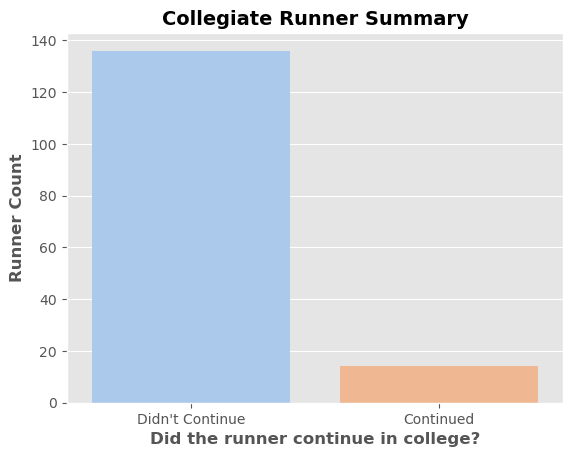

In [72]:
# use a seaborn countplot display the Y Variable showing how many top runners from California ran in college

Y_variable_plot = sns.countplot(data=data_timedelta, x='RUN_IN_COLLEGE_VARSITY?', palette='pastel')
Y_variable_plot.set_xlabel("Did the runner continue in college?", fontsize=12, weight='bold')
Y_variable_plot.set_ylabel("Runner Count", fontsize=12, weight='bold')
Y_variable_plot.set_xticklabels(["Didn't Continue", "Continued"])
Y_variable_plot.set_title("Collegiate Runner Summary", fontsize=14, weight='bold')

# Save the plot to the graph folder
filename = "y_variable_plot.png"
filepath = os.path.join(GRAPH_DIR, filename)
Y_variable_plot.figure.savefig(filepath)

In [68]:

# Breakdown by division
div_counts = data_timedelta.groupby('COLLEGE1_DIV')['RUN_IN_COLLEGE_VARSITY?'].sum()
div_percents = div_counts / div_counts.sum() * 100



In [55]:
# Print the breakdown of runners in college by division
div_table = pd.concat([div_counts, div_percents], axis=1)
div_table.columns = ['Number of runners', 'Percentage of runners']
div_table.index.name = 'College Division'
div_table.index = div_table.index.map({0: "D0 (didn't run in college)", 1: "D1", 2: "D2", 3: "D3"})
div_table['Percentage of runners'] = div_table['Percentage of runners'].apply(lambda x: f"{x:.2f}%")
print(div_table)

                            Number of runners Percentage of runners
College Division                                                   
D0 (didn't run in college)                  1                 7.14%
D1                                          8                57.14%
D2                                          2                14.29%
D3                                          3                21.43%


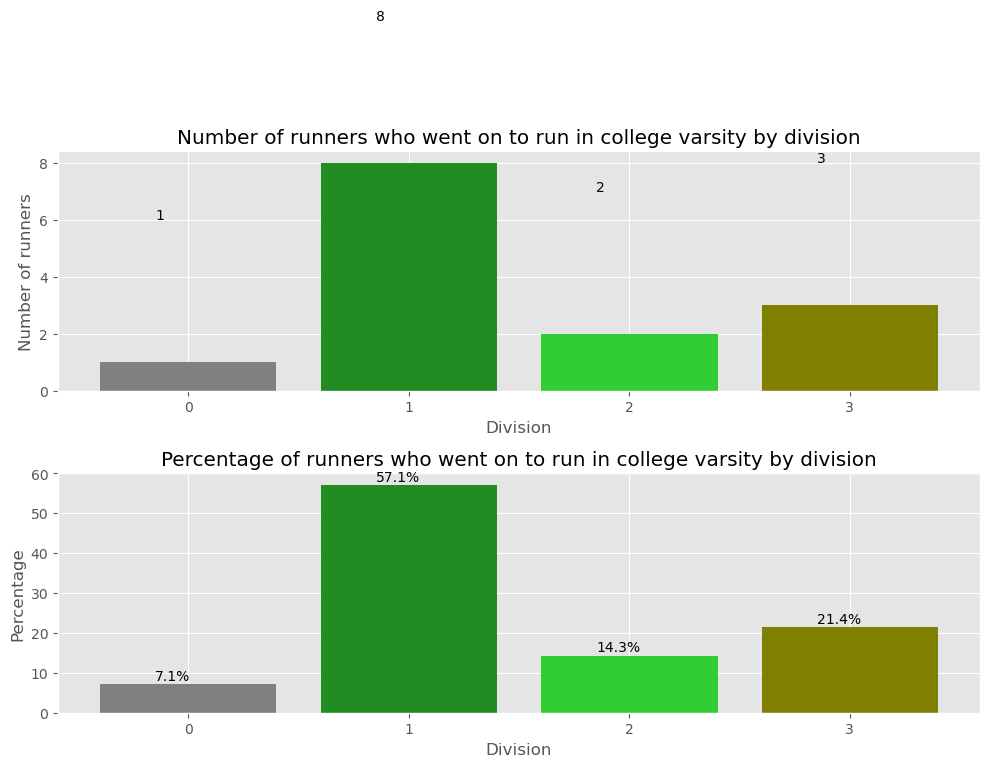

In [74]:
# Graph number and percentage of runners who went on to run in college varsity by division
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
ax1.bar(div_counts.index.astype(str), div_counts.values, color=['grey', 'forestgreen', 'limegreen', 'olive'])
ax1.set_title('Number of runners who went on to run in college varsity by division')
ax1.set_xlabel('Division')
ax1.set_ylabel('Number of runners')
for i, v in enumerate(div_counts.values):
    ax1.text(i - 0.15, v + 5, str(v))
ax2.bar(div_percents.index.astype(str), div_percents.values, color=['grey', 'forestgreen', 'limegreen', 'olive'])
ax2.set_title('Percentage of runners who went on to run in college varsity by division')
ax2.set_xlabel('Division')
ax2.set_ylabel('Percentage')
for i, v in enumerate(div_percents.values):
    ax2.text(i - 0.15, v + 1, f"{v:.1f}%")
plt.tight_layout()


# Save the graphs to the graph foder
fig.savefig(os.path.join(GRAPH_DIR, 'number_of_runners_by_college_division.png'))
fig.savefig(os.path.join(GRAPH_DIR, 'percentage_of_runners_by_college_division.png'))

# Show the graphs
plt.show()


In [57]:

# Breakdown by in-state/out-of-state
state_counts = data_timedelta.groupby('COLL1_OUT_OF_STATE')['RUN_IN_COLLEGE_VARSITY?'].sum()
state_percents = state_counts / state_counts.sum() * 100


In [73]:
# Create table
table = pd.DataFrame({'Counts': state_counts, 'Percentages': state_percents})

# Print table
print(table)

                    Counts  Percentages
COLL1_OUT_OF_STATE                     
False                    7         50.0
True                     7         50.0


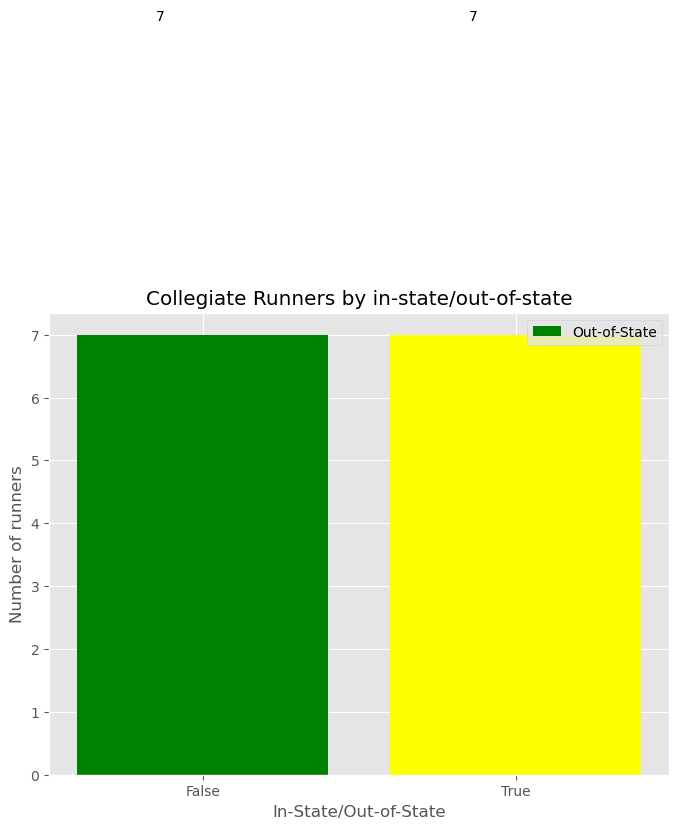

In [75]:
# Graph : Number of runners who went on to run in college varsity by in-state/out-of-state

fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(state_counts.index.astype(str), state_counts.values, color=['green', 'yellow'])
ax.set_title('Collegiate Runners by in-state/out-of-state')
ax.set_xlabel('In-State/Out-of-State')
ax.set_ylabel('Number of runners')
for i, v in enumerate(state_counts.values):
    ax.text(i - 0.15, v + 5, str(v))
ax.legend(['Out-of-State', 'In-State'])
plt.show()

#Save figure
fig.savefig(os.path.join(GRAPH_DIR, 'collegiate_runners_by_state_number.png'))


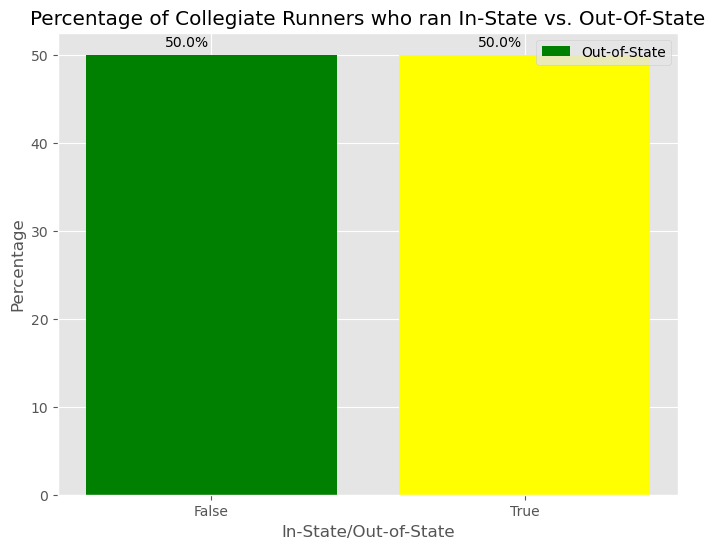

In [76]:
# Graph: Percentage of runners who went on to run in college varsity by in-state/out-of-state

fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(state_percents.index.astype(str), state_percents.values, color=['green', 'yellow'])
ax.set_title('Percentage of Collegiate Runners who ran In-State vs. Out-Of-State')
ax.set_xlabel('In-State/Out-of-State')
ax.set_ylabel('Percentage')
for i, v in enumerate(state_percents.values):
    ax.text(i - 0.15, v + 1, f"{v:.1f}%")
ax.legend(['Out-of-State', 'In-State'])
plt.show()

# Save figure
fig.savefig(os.path.join(GRAPH_DIR, 'collegiate_runners_by_state_percentage.png'))

#### Analyze the number of runners who improved their Mile Times from High School to College 

In [61]:
import matplotlib.pyplot as plt

# Calculate the number and percentage of runners who got faster in college
num_faster = data_timedelta['FASTER_MILE'].sum()
pct_faster = num_faster / len(data_timedelta) * 100

# Print the results
print(f"{num_faster} runners ({pct_faster:.1f}%) got faster in the mile in college.")

9 runners (6.0%) got faster in the mile in college.


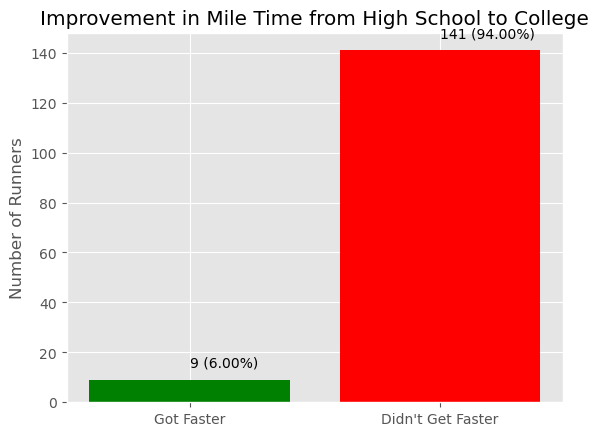

In [77]:
# Display results as a bar graph
fig, ax = plt.subplots()
ax.bar(['Got Faster', "Didn't Get Faster"], [num_faster, len(data_timedelta) - num_faster], 
       color=['green', 'red'])
ax.set_ylabel('Number of Runners')
ax.set_title('Improvement in Mile Time from High School to College')
ax.text(0, num_faster + 5, f'{num_faster} ({pct_faster:.2f}%)')
ax.text(1, len(data_timedelta) - num_faster + 5, f'{len(data_timedelta) - num_faster} ({100 - pct_faster:.2f}%)')


# Save figure
fig.savefig(os.path.join(GRAPH_DIR, 'mile_improvement.png'))

plt.show()


# DATA MODELS 

## PHASE 1 for EARLY DATA EXPLORATION (EDA) 

### SIMPLE REGRESSION MODEL TO PREDICT IF A RUNNER WILL GET FASTER IN THE MILE IN COLLEGE 

In [131]:
#### Reduce the dataframe to just the columns to include in the modeling
modeling_data = data_timedelta.loc[:, ['YEAR', 'DIVISION', 'PLACE', 'FULL_NAME', 
                                       'HS_YR', 'SCHOOL', 'SECTION', 'OVERALL TIME', 
                                       'RUN_IN_COLLEGE_VARSITY?', 'COLLEGE_1', 'COLL1_OUT_OF_STATE', 'COLLEGE1_DIV', 
                                       'BEST_COLLEGE1_8K_XC_TIME', 'BEST_COLLEGE1_5K', 'BEST_COLLEGE1_3K', 
                                       'HS_CALC_MILE', 'COLLEGE1_CALC_MILE', 'FASTER_MILE', 'MILE_IMPROVEMENT']]

In [132]:
print(modeling_data.shape)

(150, 19)


In [133]:
modeling_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype          
---  ------                    --------------  -----          
 0   YEAR                      150 non-null    int64          
 1   DIVISION                  150 non-null    int64          
 2   PLACE                     150 non-null    int64          
 3   FULL_NAME                 150 non-null    object         
 4   HS_YR                     150 non-null    int64          
 5   SCHOOL                    150 non-null    object         
 6   SECTION                   150 non-null    object         
 7   OVERALL TIME              150 non-null    timedelta64[ns]
 8   RUN_IN_COLLEGE_VARSITY?   150 non-null    bool           
 9   COLLEGE_1                 18 non-null     object         
 10  COLL1_OUT_OF_STATE        150 non-null    bool           
 11  COLLEGE1_DIV              150 non-null    int64          
 12  BEST_COL

#### Clean data more for modeling 

In [103]:

# identify columns with timedelta data type
timedelta_cols = modeling_data.select_dtypes(include='timedelta64').columns

# check for integer values in the timedelta columns
#integer_mask = modeling_data[timedelta_cols].applymap(lambda x: isinstance(x, int))

# replace integers with NaN in timedelta columns
#modeling_data[timedelta_cols] = modeling_data[timedelta_cols].replace(integer_mask, np.nan)

# replace NaN with 0 in timedelta columns
#modeling_data[timedelta_cols] = modeling_data[timedelta_cols].fillna(pd.Timedelta(0))

# convert HS_CALC_MILE to numeric (total seconds)
#modeling_data['HS_CALC_MILE'] = pd.to_numeric(modeling_data['HS_CALC_MILE'], errors='coerce')

# drop any rows with missing values
# modeling_data.dropna(inplace=True)





In [134]:
# Keep only the first 20 rows that i have data for so far
modeling_data = modeling_data.head(20)

In [122]:
# drop columns that aren't used in regression for now
#modeling_data.drop('FULL_NAME', axis=1, inplace=True)


In [135]:
# fill any remaining missing values with 0
#modeling_data.fillna(0, inplace=True)

In [136]:
# convert categorical variables (SCHOOL and SECTION) to numeric using one-hot encoding
modeling_data = pd.get_dummies(modeling_data, columns=['SCHOOL', 'SECTION'])

In [175]:
modeling_data

,YEAR,DIVISION,PLACE,FULL_NAME,HS_YR,OVERALL TIME,RUN_IN_COLLEGE_VARSITY?,COLLEGE_1,COLL1_OUT_OF_STATE,COLLEGE1_DIV,...,SCHOOL_Salesian,SCHOOL_San Lorenzo Valley,SCHOOL_San Luis Obispo,SCHOOL_San Rafael,SECTION_CCS,SECTION_CS,SECTION_NCS,SECTION_SDS,SECTION_SJS,SECTION_SS
0,2016,4,1,Callum Bolger,4,0 days 00:14:57.000004,True,Stanford,False,1,...,0,0,1,0,0,0,0,0,0,1
1,2016,4,2,Jared Rodriguez,4,0 days 00:15:29.000003,False,unknown,False,0,...,0,0,0,0,0,0,0,0,0,1
2,2016,4,3,Joseph Garcia,4,0 days 00:15:33.000009,True,Loyola Marymount Collegiate,False,1,...,1,0,0,0,0,0,0,0,0,1
3,2016,4,4,Ryan Cutter,4,0 days 00:15:39.000009,True,University of Chicago,True,3,...,0,0,0,0,0,0,1,0,0,0
4,2016,4,5,Anthony Grover,1,0 days 00:15:40.000001,True,Wake Forest,True,1,...,0,0,0,0,0,0,0,0,0,1
5,2016,4,6,Kellen O'Neill,4,0 days 00:15:42.000007,True,UC Santa Cruz,False,3,...,0,0,0,0,0,0,1,0,0,0
6,2016,4,7,Ivan Ayala,4,0 days 00:15:50.000006,False,unknown,False,0,...,0,0,0,0,0,1,0,0,0,0
7,2016,4,8,Henry Pick,2,0 days 00:15:52.000002,True,Claremont Mudd Scripps,False,3,...,0,0,0,0,0,0,0,0,0,1
8,2016,4,9,Trent Robinett,4,0 days 00:15:54.000004,False,University of Notre Dame Club,True,1,...,0,0,0,0,0,0,0,0,0,1
9,2016,4,10,Munir Kabbara,3,0 days 00:15:55.000007,True,UC Los Angeles,False,1,...,0,0,0,1,0,0,1,0,0,0


In [112]:
print(modeling_data.shape)

(20, 36)


In [126]:
# Define X independent variables to be: DIVISION, PLACE, HS_YR, SECTION, OVERALL TIME, HS_CALC_MILE 
         
modeling_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 36 columns):
 #   Column                      Non-Null Count  Dtype          
---  ------                      --------------  -----          
 0   YEAR                        20 non-null     int64          
 1   DIVISION                    20 non-null     int64          
 2   PLACE                       20 non-null     int64          
 3   HS_YR                       20 non-null     int64          
 4   OVERALL TIME                20 non-null     timedelta64[ns]
 5   RUN_IN_COLLEGE_VARSITY?     20 non-null     bool           
 6   COLLEGE_1                   18 non-null     object         
 7   COLL1_OUT_OF_STATE          20 non-null     bool           
 8   COLLEGE1_DIV                20 non-null     int64          
 9   BEST_COLLEGE1_8K_XC_TIME    13 non-null     timedelta64[ns]
 10  BEST_COLLEGE1_5K            9 non-null      timedelta64[ns]
 11  BEST_COLLEGE1_3K            11 non-null     tim

In [176]:
# split the data into training and testing sets
cols_to_drop = ['YEAR','FULL_NAME', 'RUN_IN_COLLEGE_VARSITY?', 'COLLEGE_1', 'COLL1_OUT_OF_STATE', 'COLLEGE1_DIV', 'BEST_COLLEGE1_8K_XC_TIME', 'BEST_COLLEGE1_5K', 'BEST_COLLEGE1_3K', 'COLLEGE1_CALC_MILE', 'FASTER_MILE', 'MILE_IMPROVEMENT']
X = modeling_data.drop(cols_to_drop, axis=1)
X['HS_CALC_MILE'] = X['HS_CALC_MILE'].fillna(pd.Timedelta(seconds=0))
y = modeling_data['RUN_IN_COLLEGE_VARSITY?']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [177]:
print(X)

    DIVISION  PLACE  HS_YR           OVERALL TIME           HS_CALC_MILE  \
0          4      1      4 0 days 00:14:57.000004 0 days 00:04:05.000006   
1          4      2      4 0 days 00:15:29.000003        0 days 00:00:00   
2          4      3      4 0 days 00:15:33.000009        0 days 00:00:00   
3          4      4      4 0 days 00:15:39.000009 0 days 00:04:07.000004   
4          4      5      1 0 days 00:15:40.000001 0 days 00:04:11.500006   
5          4      6      4 0 days 00:15:42.000007 0 days 00:04:21.500003   
6          4      7      4 0 days 00:15:50.000006        0 days 00:00:00   
7          4      8      2 0 days 00:15:52.000002 0 days 00:04:26.000003   
8          4      9      4 0 days 00:15:54.000004 0 days 00:04:26.500009   
9          4     10      3 0 days 00:15:55.000007 0 days 00:04:16.500001   
10         4     11      4 0 days 00:15:57.000002 0 days 00:04:20.500008   
11         4     12      2 0 days 00:15:57.000006 0 days 00:04:20.500008   
12         4

NOTE: The columns OVERALL TIME and HS_CALC_MILE are Timedelta objects which cannot be converted to float values required by LinearRegression. Convert to numerical values before training the model. b

In [178]:
# convert timedelta columns to numerical values
X_train['OVERALL TIME'] = X_train['OVERALL TIME'].apply(lambda x: x.total_seconds())
X_train['HS_CALC_MILE'] = X_train['HS_CALC_MILE'].apply(lambda x: x.total_seconds() / 60)

X_test['OVERALL TIME'] = X_test['OVERALL TIME'].apply(lambda x: x.total_seconds())
X_test['HS_CALC_MILE'] = X_test['HS_CALC_MILE'].apply(lambda x: x.total_seconds() / 60)



In [186]:

# create and train the model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# make predictions on the test set and calculate accuracy score
y_pred = lr_model.predict(X_test)
y_pred = [1 if x > 0.5 else 0 for x in y_pred] # convert probabilities to binary predictions
accuracy = accuracy_score(y_test, y_pred)


print('Accuracy:', accuracy)


Accuracy: 0.25


In [188]:

# add predictions as a column to modeling_data
#modeling_data['LR_PRED1'] = y_pred

In [184]:

# create a dataframe with X_test, y_test, and y_pred values
lr_model_results = pd.DataFrame({'X': X_test.iloc[:, 0], 'y_true': y_test, 'y_pred': y_pred})
print(lr_model_results)

    X  y_true  y_pred
0   4    True       0
17  4    True       0
15  4    True       1
1   4   False       1


### PHASE 1: Enhanced Linear Regression Pipeline for Preliminary EDA 

Create a modeling pipeline using a constant to fill in missing values with a mean, a standard scaler to scale the features, a feature selector to choose the top k features, and a linear regression model. 

In [162]:
# define the pipeline
pipeline = Pipeline([
    #('imputer', SimpleImputer(strategy='constant', fill_value=0)), # fill missing values with 0
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest()),
    ('regression', LinearRegression())
])

In [163]:
# define the hyperparameter space to search over
param_grid = {
    'feature_selection__k': [5, 10, 15],
    'regression__fit_intercept': [True, False],
}

Use grid search to search over a range of hyperparameters for the feature selection and regression steps. 

In [164]:
# perform grid search with cross-validation to find the best hyperparameters
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 0  5  9 13 16 17 19] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 0 11 17 23] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 0 15 17 18] are constant.
  warnings.warn("Features %s are con

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('feature_selection', SelectKBest()),
                                       ('regression', LinearRegression())]),
             param_grid={'feature_selection__k': [5, 10, 15],
                         'regression__fit_intercept': [True, False]})

In [190]:
# Assuming X is your dataset
#for i in range(X.shape[1]):
#    unique_vals = np.unique(X[:, i])
 #   if len(unique_vals) == 1:
   #     print(f"Feature {i} is constant with value {unique_vals[0]}")

Make predictions on the test set and calculate the accuracy score.


In [160]:
# make predictions on the test set and calculate accuracy score
y_pred = grid_search.predict(X_test)
y_pred = [1 if x > 0.5 else 0 for x in y_pred] # convert probabilities to binary predictions
accuracy = accuracy_score(y_test, y_pred)

In [161]:
print('Best hyperparameters:', grid_search.best_params_)
print('Accuracy:', accuracy)

Best hyperparameters: {'feature_selection__k': 15, 'regression__fit_intercept': True}
Accuracy: 0.25


### FUTURE: SIMPLE REGRESSION MODEL TO PREDICT IF A RUNNER WILL GET FASTER IN THE MILE IN COLLEGE 

# MODEL CONCLUSIONS/LEARNINGS


## PHASE 1 for EARLY DATA EXPLORATION (EDA) 


With very little data (20 rows) a Linear Regression model can be applied against the top California running data from 2016 to predict if the athlete will run in college with only 25% accuracy - but this will increase with more data I'm pretty sure..... just phase 1 of understanding and sourcing the data
